In [0]:
#@title
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install torch torchvision
!pip install --no-cache-dir -I pillow
!pip install astropy --no-deps

    100% |████████████████████████████████| 2.0MB 38.0MB/s 


# Import Packages

In [0]:
#@title
from __future__ import print_function
import matplotlib.pyplot as plt
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval as zscale

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch.optim

from skimage.measure import compare_psnr
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch.optim

from skimage.measure import compare_psnr
from astropy.modeling.models import Gaussian2D

In [0]:
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from scipy.ndimage.filters import gaussian_filter
import torch.nn.functional as F

In [0]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.HalfTensor
torch.cuda.is_available()


# Define Necessary Functions
functions are from deep image prior  https://dmitryulyanov.github.io/deep_image_prior

In [0]:
 
def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
    return net_input

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False
        
import torch.nn as nn

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net
  
def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.
    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')
    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))
            
        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())
    return model
  
def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)
  
  
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.
    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters[0], lr=LR)
        stn_optimizer = torch.optim.Adam(parameters[1], lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.95)
        stn_scheduler = torch.optim.lr_scheduler.ExponentialLR(stn_optimizer,0.95)
        for j in range(num_iter):
          optimizer.zero_grad()
          stn_optimizer.zero_grad()
          closure()
          optimizer.step()
          stn_optimizer.step()
          if j % 500 == 0 and j!= 0:
            scheduler.step()
            stn_scheduler.step()
    else:
      assert False
      
### Downsampler

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'
       
        elif kernel_type == 'gauss2':
            kernel_width = 19
            sigma = 2
            kernel_type_ = 'gauss'
            
        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel
  
def get_params(opt_over, net_list, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
          for net in net_list:
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params
  
    
def make_down_net():
  
  model = [nn.Conv2d(1,1,11,4,bias=True,padding=4)]
  model = nn.Sequential(*model)
 # model.add(nn.Conv2d(1,1,7,2,bias=True,padding=4))
 # model.add(nn.Conv2d(1,1,7,1,bias=True,padding=2))  
#  model.add(nn.Conv2d(1,1,7,2,bias=True,padding=4))
  
  return model    


# STN
-  Downsamples
-  Uses pytorch sample stn

In [0]:

# stn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 159 * 159, 32),  # hard coded for images that are 650x650 
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
       # print(x.shape)
        xs = self.localization(x)
       # print(xs.shape)
        xs = xs.view(-1, 10 * 159 * 159) # hard coded for images that are 650x650 
       # print(xs.shape)
        theta = self.fc_loc(xs)
       # print(theta.shape)
        theta = theta.view(-1, 2, 3)
       # print(theta.shape)

        grid = F.affine_grid(theta, x.size())
       # print(grid.shape)
        x = F.grid_sample(x, grid)
       # print(x.shape)

        return x

    def forward(self, x):
        down = nn.Conv2d(1,1,11,2,bias=True,padding=5)
        x = down(x)
        x = self.stn(x)

    
        return x

# Load Data
-  Load fits files of pluto
-  Normalize image between 0 & 1
-  Convert to Torch Tensor

.config
cutout_lor_0299124424_0x636_eng.fit
(650, 650)


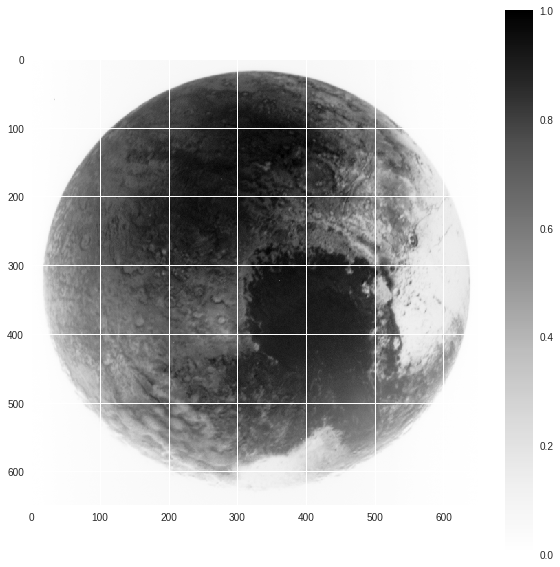

cutout_lor_0299122939_0x636_eng.fit
(650, 650)


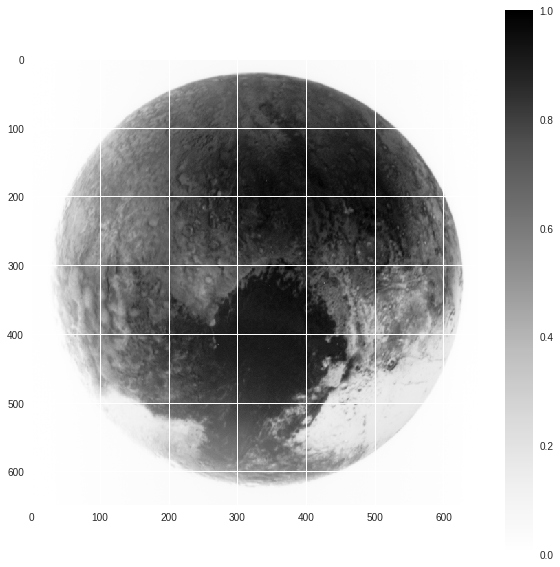

cutout_lor_0299124574_0x630_eng.fit
(650, 650)


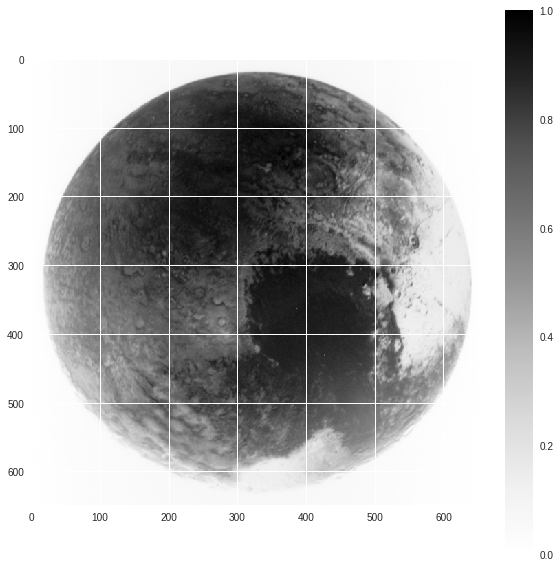

.ipynb_checkpoints
cutout_lor_0299124514_0x636_eng.fit
(650, 650)


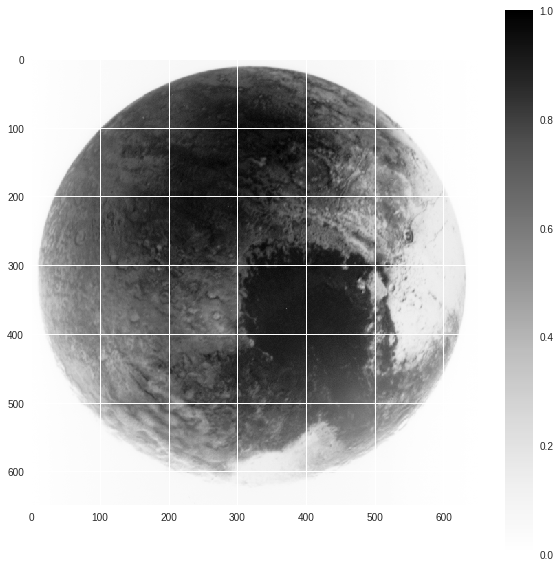

cutout_lor_0299124469_0x636_eng.fit
(650, 650)


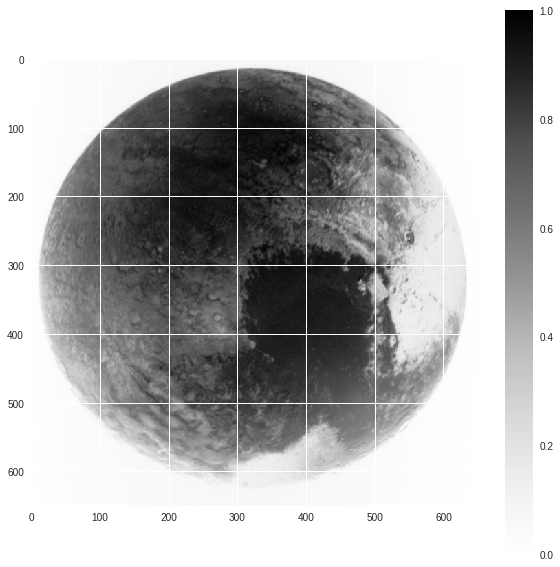

cutout_lor_0299123689_0x630_eng.fit
(650, 650)


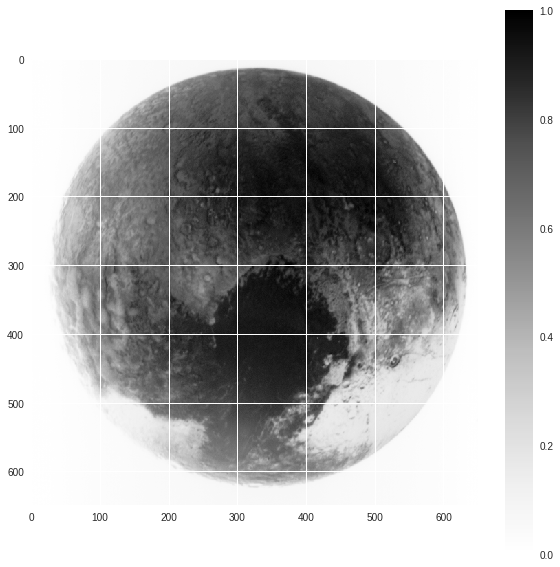

cutout_lor_0299124379_0x636_eng.fit
(650, 650)


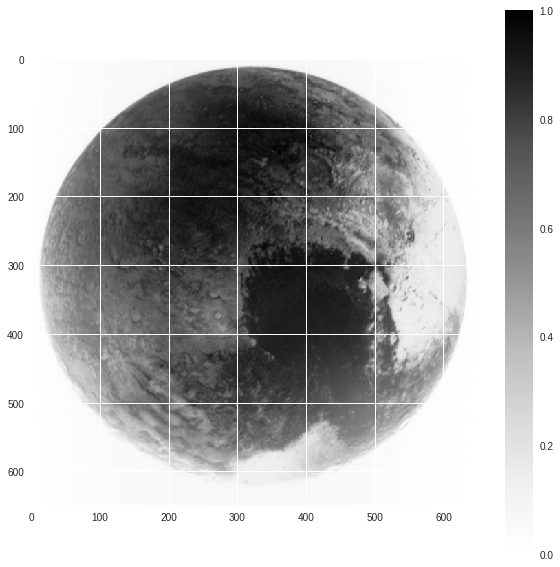

cutout_lor_0299122189_0x630_eng.fit
(650, 650)


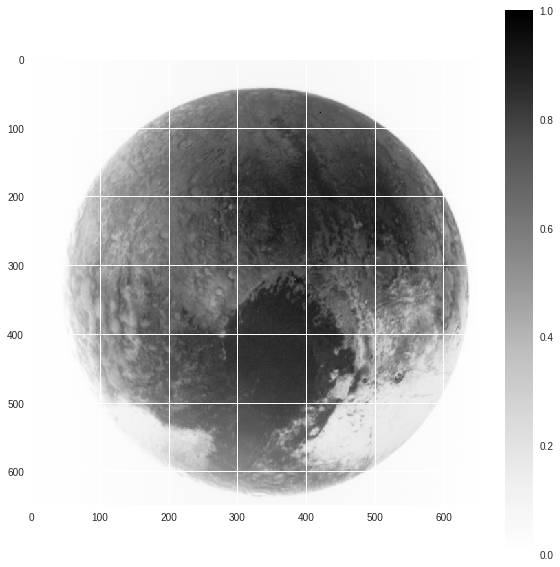

sample_data


In [0]:
pluto = []
for file in os.listdir(os.getcwd()):
    print(file)
    if file.endswith('.fit'):
      x = fits.open(file)[0].data
      print(x.shape)
      x_shape = (x - np.min(x))/(np.max(x) - np.min(x))
      pluto_torch = np_to_torch(x_shape).type(dtype)
      pluto.append(pluto_torch)
      figure = plt.figure(figsize=(10,10))
      plt.imshow(x_shape)
      plt.colorbar()  
      plt.show()
      
    
  

In [0]:
pluto = torch.stack(pluto)
pluto = pluto.type(torch.FloatTensor)
pluto.shape

torch.Size([8, 1, 650, 650])

In [0]:

torch.cuda.memory_allocated()

845312

In [0]:
#@title
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype =	torch.cuda.HalfTensor
imsize = -1 
factor = 2 # 8


In [0]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.05

OPTIMIZER = 'adam'

if factor == 2: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

# Get Net
-  Randomly initalize latent vector z 
-  Declare net type and initialize
-  Get STNs
-  Declare loss function

In [0]:
net_input = get_noise(input_depth, INPUT, (pluto.shape[2] * 2, pluto.shape[3] * 2)).type(torch.cuda.FloatTensor).detach()
print(torch.cuda.memory_allocated())
NET_TYPE = 'skip' # UNet, ResNet

net = get_net(input_depth,'skip', 'zero',
              n_channels=1,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(torch.cuda.FloatTensor)
print(torch.cuda.memory_allocated())
down_net = []
for i in range(pluto.shape[0]):
  stn_model = Net()
  down_net.append(stn_model.type(torch.FloatTensor))
print(torch.cuda.memory_allocated())


217245184
226179584
226179584


In [0]:
mse = torch.nn.MSELoss().type(torch.FloatTensor)
print(torch.cuda.memory_allocated())

226179584


In [0]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
print(torch.cuda.memory_allocated())


658979328


# Define Closure Function
-  function that optimizes net parameters 

In [0]:
def closure():
    global i, net_input, k, output_list
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_HR_np = torch_to_np(out_HR)
    if i % 100 == 0:
      print(torch.cuda.memory_allocated())
   
    for k in range(pluto.shape[0]):
      out_LR = down_net[k](out_HR.type(torch.FloatTensor))
      if k == 0:
        total_loss = mse(out_LR[0], pluto[k]) 
      else:
        total_loss += mse(out_LR[0], pluto[k]) 
    del out_HR
    
    if i % 100 == 0:
      print(torch.cuda.memory_allocated())        
    
    total_loss.backward(retain_graph=True)
    
    if i % 100 == 0:
      print(torch.cuda.memory_allocated())        
    
    if i % 100 == 0:
      output_list.append(out_HR_np) 
      print(i)
      print(out_HR_np.shape)
      print("total loss = ",total_loss)
      
      figure = plt.figure(figsize=(10,10))
      plt.imshow(out_HR_np[0])
      plt.colorbar(fraction = 0.046)
      plt.title("Ouput")
      
      plt.show()
   
    i += 1
    
    return total_loss


# Optimization
-  Get net parameters to optimize over
-  Optimize

i = 0
output_list = []

net_list = [net] 
p = [get_params(OPT_OVER, net_list, net_input),get_params(OPT_OVER, down_net, net_input)]
    
optimize(OPTIMIZER, p, closure, LR, 2000)

In [0]:
out_HR = net(net_input)
out_HR_np = torch_to_np(out_HR)
output_list.append(out_HR_np) 

# Save output

In [0]:
data, hdr = fits.getdata("cutout_SloanR_2017-03-25-T13110630_11_light_ds_ff.fits", 0, header=True)

for i in range(len(output_list)):
  fits.writeto(str(i)+'anneal_lr_SR_SloanR.fits', output_list[i], header=hdr, overwrite =True)
  files.download(str(i)+'anneal_lr_SR_SloanR.fits')